In [1]:
using LinearAlgebra
using SparseArrays
using ArnoldiMethod
using PyPlot

Degenerate perturbation theory for two fermions in a bosonic bath at unit filling on a lattice of L sites, the inter and intraspecies interactions are infinite, the perturbation is done on the hopping terms.

In [2]:
function GenerateLabels(L)
    Labels = Dict()
    n = 0
    for ii in 1:L
        for jj in ii+1:L
            for kk in 1:L
                for ll in kk+1:L
                    n += 1
                    Labels[(ii,jj,kk,ll)] = n
                end
            end
        end
    end
    return Labels
end

GenerateLabels (generic function with 1 method)

In [3]:
function AddTerm!(X, Y, V, x, y, v)
    push!(X, x)
    push!(Y, y)
    push!(V, v)
end

function ConstructHamiltonian(L, Labels, boundary=:OO)
    if boundary == :OO
        X = Vector{Float64}()
        Y = Vector{Float64}()
        V = Vector{Float64}()
        
        for ii in 1:L
            for jj in ii+1:L
                for kk in 1:L
                    for ll in kk+1:L
                        x = get(Labels, (ii,jj,kk,ll), 0)
    
                        # Fermion hopping
                        if ii == ll
                            y = get(Labels, (ii-1,jj,kk,ll-1), 0)
                            AddTerm!(X, Y, V, x, y, -1.)
                            y = get(Labels, (ii+1,jj,kk,ll+1), 0)
                            AddTerm!(X, Y, V, x, y, -1.)
                        elseif jj == kk
                            y = get(Labels, (ii,jj-1,kk-1,ll), 0)
                            AddTerm!(X, Y, V, x, y, -1.)
                            y = get(Labels, (ii,jj+1,kk+1,ll), 0)
                            AddTerm!(X, Y, V, x, y, -1.)
                        else
                            if ii == kk
                                y = get(Labels, (ii-1,jj,kk-1,ll), 0)
                                AddTerm!(X, Y, V, x, y, -1.)
                                y = get(Labels, (ii+1,jj,kk+1,ll), 0)
                                AddTerm!(X, Y, V, x, y, -1.)
                            end
                            if jj == ll
                                y = get(Labels, (ii,jj-1,kk,ll-1), 0)
                                AddTerm!(X, Y, V, x, y, -1.)
                                y = get(Labels, (ii,jj+1,kk,ll+1), 0)
                                AddTerm!(X, Y, V, x, y, -1.)
                            end
                        end
    
                        # Boson hopping
                        bᵏ = 1.
                        if kk ≠ ii && kk ≠ jj
                            bᵏ *= √2
                        end
    
                        bᵏ⁻ = 1.
                        if kk-1 ≠ ii && kk-1 ≠ jj
                            bᵏ⁻ *= √2
                        end
    
                        bᵏ⁺ = 1.
                        if kk+1 ≠ ii && kk+1 ≠ jj
                            bᵏ⁺ *= √2
                        end
                        
                        bˡ = 1.
                        if ll ≠ ii && ll ≠ jj
                            bˡ *= √2
                        end
    
                        bˡ⁻ = 1.
                        if ll-1 ≠ ii && ll-1 ≠ jj
                            bˡ⁻ *= √2
                        end
    
                        bˡ⁺ = 1.
                        if ll+1 ≠ ii && ll+1 ≠ jj
                            bˡ⁺ *= √2
                        end
                        
                        y = get(Labels, (ii,jj,kk-1,ll), 0)
                        AddTerm!(X, Y, V, x, y, -bᵏ*bᵏ⁻)
                        y = get(Labels, (ii,jj,kk+1,ll), 0)
                        AddTerm!(X, Y, V, x, y, -bᵏ*bᵏ⁺)
                        y = get(Labels, (ii,jj,kk,ll-1), 0)
                        AddTerm!(X, Y, V, x, y, -bˡ*bˡ⁻)
                        y = get(Labels, (ii,jj,kk,ll+1), 0)
                        AddTerm!(X, Y, V, x, y, -bˡ*bˡ⁺)
                        
                    end
                end
            end
        end
    
        # Filter non included values
        extra = findall(jj -> jj == 0, Y)
        deleteat!(V, extra)
        deleteat!(X, extra)
        deleteat!(Y, extra)
    
        ΔH = sparse(X, Y, V)
        return Symmetric(ΔH)
        
    elseif boundary == :CO

        δd(ll, L) = (ll-1+L)%L+1
        
        X = Vector{Float64}()
        Y = Vector{Float64}()
        V = Vector{Float64}()
        
        for ii in 1:L
            for jj in ii+1:L
                for kk in 1:L
                    for ll in kk+1:L
                        x = get(Labels, (ii,jj,kk,ll), 0)
    
                        # Fermion hopping
                        if ii == ll
                            y = get(Labels, (ii-1,jj,kk,ll-1), 0)
                            AddTerm!(X, Y, V, x, y, -1.)
                            y = get(Labels, (ii+1,jj,kk,ll+1), 0)
                            AddTerm!(X, Y, V, x, y, -1.)
                        elseif jj == kk
                            y = get(Labels, (ii,jj-1,kk-1,ll), 0)
                            AddTerm!(X, Y, V, x, y, -1.)
                            y = get(Labels, (ii,jj+1,kk+1,ll), 0)
                            AddTerm!(X, Y, V, x, y, -1.)
                        else
                            if ii == kk
                                y = get(Labels, (ii-1,jj,kk-1,ll), 0)
                                AddTerm!(X, Y, V, x, y, -1.)
                                y = get(Labels, (ii+1,jj,kk+1,ll), 0)
                                AddTerm!(X, Y, V, x, y, -1.)
                            end
                            if jj == ll
                                y = get(Labels, (ii,jj-1,kk,ll-1), 0)
                                AddTerm!(X, Y, V, x, y, -1.)
                                y = get(Labels, (ii,jj+1,kk,ll+1), 0)
                                AddTerm!(X, Y, V, x, y, -1.)
                            end
                        end
    
                        # Boson hopping
                        bᵏ = 1.
                        if kk ≠ ii && kk ≠ jj
                            bᵏ *= √2
                        end
    
                        bᵏ⁻ = 1.
                        if δd(kk-1, L) ≠ ii && δd(kk-1, L) ≠ jj
                            bᵏ⁻ *= √2
                        end
    
                        bᵏ⁺ = 1.
                        if δd(kk+1, L) ≠ ii && δd(kk+1, L) ≠ jj
                            bᵏ⁺ *= √2
                        end
                        
                        bˡ = 1.
                        if ll ≠ ii && ll ≠ jj
                            bˡ *= √2
                        end
    
                        bˡ⁻ = 1.
                        if δd(ll-1, L) ≠ ii && δd(ll-1, L) ≠ jj
                            bˡ⁻ *= √2
                        end
    
                        bˡ⁺ = 1.
                        if δd(ll+1, L) ≠ ii && δd(ll+1, L) ≠ jj
                            bˡ⁺ *= √2
                        end

                        if kk == 1
                            y = get(Labels, (ii,jj,ll,δd(kk-1, L)), 0)
                            AddTerm!(X, Y, V, x, y, -bᵏ*bᵏ⁻)
                        else
                            y = get(Labels, (ii,jj,kk-1,ll), 0)
                            AddTerm!(X, Y, V, x, y, -bᵏ*bᵏ⁻)
                        end 
                        y = get(Labels, (ii,jj,kk+1,ll), 0)
                        AddTerm!(X, Y, V, x, y, -bᵏ*bᵏ⁺)
                        y = get(Labels, (ii,jj,kk,ll-1), 0)
                        AddTerm!(X, Y, V, x, y, -bˡ*bˡ⁻)
                        if ll == L
                            y = get(Labels, (ii,jj,δd(ll+1, L),kk), 0)
                            AddTerm!(X, Y, V, x, y, -bˡ*bˡ⁺)
                        else
                            y = get(Labels, (ii,jj,kk,ll+1), 0)
                            AddTerm!(X, Y, V, x, y, -bˡ*bˡ⁺)
                        end
                        
                    end
                end
            end
        end
    
        # Filter non included values
        extra = findall(jj -> jj == 0, Y)
        deleteat!(V, extra)
        deleteat!(X, extra)
        deleteat!(Y, extra)
    
        ΔH = sparse(X, Y, V)
        return Symmetric(ΔH)
    else
        return NaN
    end
end

ConstructHamiltonian (generic function with 2 methods)

In [4]:
function GetDensities(L, Labels, ψ)
    
    nᶠ = zeros(L)
    nᵇ = zeros(L)
    for Lab in Labels
        x, n = Lab
        ii, jj, kk, ll = x
        
        nᶠ[ii] += ψ[n]^2
        nᶠ[jj] += ψ[n]^2

        nᵇ_n = ones(L)
        nᵇ_n[ii] -= 1
        nᵇ_n[jj] -= 1
        nᵇ_n[kk] += 1
        nᵇ_n[ll] += 1
        nᵇ += nᵇ_n*ψ[n]^2
    end

    return nᶠ, nᵇ
end

GetDensities (generic function with 1 method)

In [8]:
L = 30
Labels = GenerateLabels(L)
print(length(Labels))
ΔH = ConstructHamiltonian(L, Labels, :OO)
decomp, history = partialschur(ΔH, nev=1, tol=1e-9, which=SR())
history

189225

Converged: 1 of 1 eigenvalues in 930 matrix-vector products

[0.14735170746010562, 0.10258398500735236, 0.08749242289353441, 0.07926638963181813, 0.073710617161545, 0.06932152560792573, 0.06538664230878324, 0.061526254533698206, 0.05753629519735569, 0.0533190783785232, 0.048856813269088493, 0.044235534528868206, 0.03973711558104772, 0.035952524067522966, 0.03372304279716886, 0.03372304575594431, 0.035952532563902156, 0.03973712866729194, 0.04423555110761619, 0.0488568323326917, 0.053319099121201724, 0.05753631696012209, 0.06152627672910046, 0.0653866643523228, 0.06932154682695246, 0.07371063666675026, 0.07926640596224971, 0.08749243349087957, 0.10258397977549459, 0.14735160126313507]

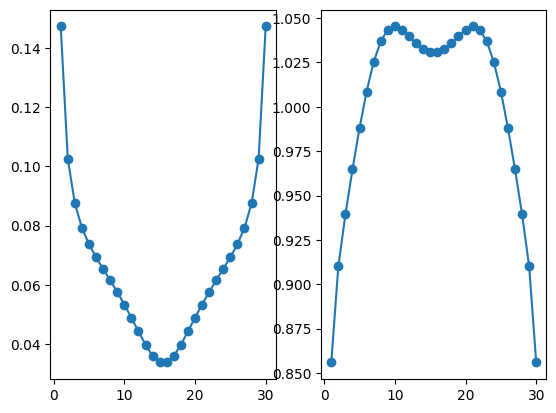

In [9]:
ψ₀ = decomp.Q[:,1]
nᶠ, nᵇ = GetDensities(L, Labels, ψ₀)
fig, axs = subplots(1, 2)
axs[1].plot(1:L, nᶠ, marker="o")
axs[2].plot(1:L, nᵇ, marker="o")
print(nᶠ)

In [5]:
L = 30
Labels = GenerateLabels(L)
ΔH = ConstructHamiltonian(L, Labels, :CO)
decomp, history = partialschur(ΔH, nev=1, tol=1e-9, which=SR())
history

Converged: 1 of 1 eigenvalues in 450 matrix-vector products

[0.0031495659438817557, 0.012317162611288414, 0.026323557499014577, 0.04327962954988577, 0.06094983720261657, 0.07710696470679324, 0.08985891166051928, 0.09791558503504008, 0.10076260124178067, 0.0987162235058775, 0.09284871558357562, 0.08479233701524093, 0.07645029267676182, 0.06966039128838712, 0.0658682449153045, 0.06586824146384192, 0.06966038196097296, 0.07645027930392573, 0.084792322004393, 0.09284870174501933, 0.0987162130563026, 0.10076259546128619, 0.09791558437520859, 0.08985891517749439, 0.07710697115760863, 0.06094984441753923, 0.043279636031396375, 0.026323561966978607, 0.012317164868948035, 0.003149566573114699]

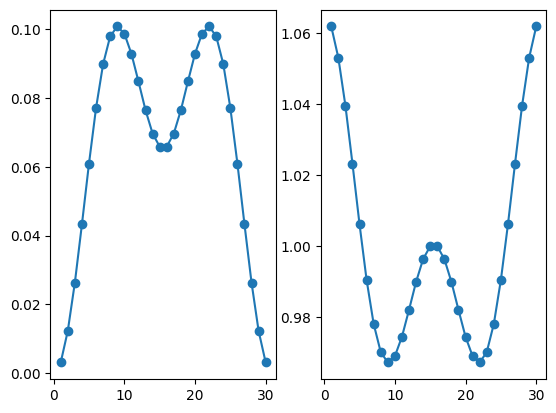

In [6]:
ψ₀ = decomp.Q[:,1]
nᶠ, nᵇ = GetDensities(L, Labels, ψ₀)
fig, axs = subplots(1, 2)
axs[1].plot(1:L, nᶠ, marker="o")
axs[2].plot(1:L, nᵇ, marker="o")
print(nᶠ)